In [1]:
import os
import sys
from pathlib import Path
from IPython.display import display

import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Display all columns in a pandas dataframe
import matplotlib.pyplot as plt

from itertools import zip_longest

cwd = Path(os.getcwd())
print(os.listdir("/"))

['bin', 'boot', 'dev', 'etc', 'home', 'lib', 'lib64', 'media', 'mnt', 'opt', 'proc', 'root', 'run', 'sbin', 'srv', 'sys', 'tmp', 'usr', 'var', 'get-docker.sh', 'dxdata-0.36.1-py2.py3-none-any.whl', 'install_r_kernel.R', 'install_r_packages.R', '.dockerenv']


## 1. Read participant data and select all postmenopausal women

In [2]:
participant_data = pd.read_csv("/mnt/project/data/HESIN/participant.csv", parse_dates=["p53_i0", "p53_i1", "p53_i2"])
participant_data

,eid,p53_i0,p53_i1,p53_i2,p2724_i0,p2724_i1,p2724_i2
0,3150890,2009-11-13,NaT,2022-05-17,Yes,NaN,Yes
1,3494109,2010-02-02,NaT,2015-08-04,Yes,NaN,Yes
2,5772321,2009-11-14,NaT,2020-02-21,Yes,NaN,Yes
3,3808193,2010-04-28,NaT,2015-02-25,Yes,NaN,Yes
4,1142544,2010-06-03,NaT,2015-08-08,No,NaN,Yes
...,...,...,...,...,...,...,...
28031,2534557,2009-12-09,NaT,2015-07-05,No,NaN,No
28032,3098005,2009-10-01,NaT,2018-08-25,Yes,NaN,Yes
28033,2781078,2008-08-07,NaT,2016-11-04,Yes,NaN,Yes
28034,3037992,2009-02-10,NaT,2018-07-24,No,NaN,Not sure - other reason


In [3]:
def find_menopause_status(row):
    if row["p2724_i0"] == "Yes" or\
    row["p2724_i1"] == "Yes" or\
    row["p2724_i2"] == "Yes":
        return True
    else:
        return False

In [4]:
# Forward fill menopause status and store value in a new column
menopausal_variables = ["p2724_i0", "p2724_i1", "p2724_i2"]
participant_data["postmenopausal"] = participant_data[menopausal_variables].apply(lambda x: find_menopause_status(x), axis=1)

# Drop old columns
participant_data.drop(menopausal_variables, axis=1, inplace=True)

# Filter for menopausal women and drop columns
pm_women = participant_data[participant_data["postmenopausal"] == True].reset_index(drop=True)
pm_women_ids = pm_women["eid"]
pm_women

,eid,p53_i0,p53_i1,p53_i2,postmenopausal
0,3150890,2009-11-13,NaT,2022-05-17,True
1,3494109,2010-02-02,NaT,2015-08-04,True
2,5772321,2009-11-14,NaT,2020-02-21,True
3,3808193,2010-04-28,NaT,2015-02-25,True
4,1142544,2010-06-03,NaT,2015-08-08,True
...,...,...,...,...,...
23532,2065661,2008-08-18,NaT,2016-02-22,True
23533,4750639,2008-03-26,NaT,2019-04-12,True
23534,3098005,2009-10-01,NaT,2018-08-25,True
23535,2781078,2008-08-07,NaT,2016-11-04,True


## 2. Extract all postmenopausal women from hesin and hesin_diag

In [5]:
hesin = pd.read_csv("/mnt/project/data/HESIN/hesin.csv", parse_dates=["elecdate", "admidate", "epistart"]).drop("dnx_hesin_id", axis=1)
hesin_diag = pd.read_csv("/mnt/project/data/HESIN/hesin_diag.csv").drop("dnx_hesin_diag_id", axis=1)

# Drop NaN's
hesin_diag.dropna(inplace=True)

# Display tables
print("HESIN")
display(hesin)
print()
print("HESIN_DIAG")
hesin_diag

HESIN


,eid,ins_index,elecdate,admidate,epistart
0,4211395,1,2014-04-07,2014-04-07,2014-04-07
1,1530100,5,2010-09-10,2011-05-10,2011-05-10
2,4698519,4,NaT,1997-12-04,1997-12-04
3,6022133,1,NaT,2015-05-03,2015-05-11
4,1377148,1,2005-10-13,2005-12-09,2005-12-09
...,...,...,...,...,...
136851,1567349,4,2018-10-29,2018-12-12,2018-12-12
136852,3370706,2,NaT,2012-03-16,2012-03-16
136853,5302973,6,NaT,2019-12-09,2019-12-09
136854,2321476,1,NaT,1998-02-24,1998-02-24



HESIN_DIAG


,eid,diag_icd10,ins_index,arr_index
0,1001273,"H26.9 Cataract, unspecified",1,0
1,1001554,"J45.9 Asthma, unspecified",12,1
2,1001554,K57.3 Diverticular disease of large intestine ...,12,0
3,1001554,N72 Inflammatory disease of cervix uteri,5,0
4,1001554,"N92.6 Irregular menstruation, unspecified",5,1
...,...,...,...,...
397397,6023403,G99.2 Myelopathy in diseases classified elsewhere,7,1
397398,6023403,M51.0 Lumbar and other intervertebral disk dis...,7,0
397399,6023403,"G40.9 Epilepsy, unspecified",7,2
397400,6023580,Z12.1 Special screening examination for neopla...,0,0


In [6]:
# select only postmenopausal women
hesin = hesin[hesin["eid"].isin(pm_women_ids)]
hesin_diag = hesin_diag[hesin_diag["eid"].isin(pm_women_ids)]
print("len(hesin.index) =", len(hesin.index))
print("len(hesin_diag.index) =", len(hesin_diag.index))

len(hesin.index) = 112140
len(hesin_diag.index) = 325478


## 3. Extract only fracture ICD codes

In [7]:
# Define ICD-10 codes belonging to each fracture type
FX_CODES = {
    "vertebral": ["S12.0", "S12.1", "S12.2", "S12.7", "S22.0", "S22.1", "S22.4", "S32.0", "S32.1", "S32.7", "M48.44", "M48.45", "M48.46", "M48.47", "M48.48", "M48.49"],
    "hip": ["S72.0", "S72.1", "S72.2"],
    "wrist": ["S62.0", "S62.1", "S62.2", "S62.3", "S62.4"],
}
FX_CODES["any"] = FX_CODES["vertebral"] + FX_CODES["hip"] + FX_CODES["wrist"] + ["M80", "S42", "S52", "S72", "S82", "S92.0", "S92.1", "S92.2", "S92.3", "S92.7", "S92.9"]

In [8]:
# Filter for relevant fracture codes
fractures = hesin_diag.loc[:, "diag_icd10"].str.startswith(tuple(FX_CODES["any"]))
hesin_fractures = hesin_diag[fractures]
hesin_fractures

,eid,diag_icd10,ins_index,arr_index
469,1022424,S22.10 Multiple fractures of thoracic spine (c...,3,1
648,1041455,S52.00 Fracture of upper end of ulna (closed),2,0
863,1053731,S52.50 Fracture of lower end of radius (closed),5,0
868,1053731,S82.50 Fracture of medial malleolus (closed),5,1
940,1056950,S52.50 Fracture of lower end of radius (closed),0,0
...,...,...,...,...
396939,5983239,S42.20 Fracture of upper end of humerus (closed),1,0
396998,5990227,S22.00 Fracture of thoracic vertebra (closed),1,0
397008,5990227,S22.40 Multiple fractures of ribs (closed),1,1
397134,5999862,S52.50 Fracture of lower end of radius (closed),1,0


In [9]:
# Merge hesin_diag with hesin to obtain date belonging to the icd10 code
hesin_fractures = hesin_fractures.set_index(["eid", "ins_index"]).join(hesin.set_index(["eid", "ins_index"]), how="left").reset_index()
hesin_fractures

,eid,ins_index,diag_icd10,arr_index,elecdate,admidate,epistart
0,1004314,0,S22.40 Multiple fractures of ribs (closed),0,NaT,2001-02-18,2001-02-18
1,1004314,0,S42.00 Fracture of clavicle (closed),2,NaT,2001-02-18,2001-02-18
2,1012995,81,S22.40 Multiple fractures of ribs (closed),1,NaT,2007-06-18,2007-06-18
3,1014638,0,S52.6 Fracture of lower end of both ulna and r...,0,NaT,2004-12-24,2004-12-24
4,1022424,3,S22.10 Multiple fractures of thoracic spine (c...,1,2015-12-21,2016-12-20,2016-12-20
...,...,...,...,...,...,...,...
1708,6005174,1,S72.30 Fracture of shaft of femur (closed),0,NaT,2021-06-01,2021-06-07
1709,6006169,0,S82.80 Fractures of other parts of lower leg (...,0,NaT,2011-01-22,2011-01-22
1710,6014820,0,S52.60 Fracture of lower end of both ulna and ...,0,NaT,2016-01-11,2016-01-11
1711,6023555,1,S82.80 Fractures of other parts of lower leg (...,0,NaT,2015-07-02,2015-07-02


In [10]:
# Check for NaN's
hesin_fractures.isna().sum()

eid              0
ins_index        0
diag_icd10       0
arr_index        0
elecdate      1351
admidate       119
epistart         3
dtype: int64

In [11]:
hesin.isna().sum()

eid              0
ins_index        0
elecdate     30168
admidate      4758
epistart      1985
dtype: int64

Why are there missing date values? Too bad :(

In [12]:
hesin_fractures[hesin_fractures["epistart"].isna()]

,eid,ins_index,diag_icd10,arr_index,elecdate,admidate,epistart
695,2932528,1,S82.0 Fracture of patella,0,NaT,1996-11-12,NaT
1038,3914638,0,S82.40 Fracture of fibula alone (closed),0,NaT,1996-07-28,NaT
1137,4310700,3,S62.30 Fracture of other metacarpal bone (closed),0,NaT,1997-01-20,NaT


In [13]:
# Fill missing values with dates from admission date
missing_date_index = hesin_fractures[hesin_fractures["epistart"].isna()].index
hesin_fractures.loc[missing_date_index, "epistart"] = hesin_fractures.loc[missing_date_index, "admidate"]
hesin_fractures.loc[missing_date_index, :]

,eid,ins_index,diag_icd10,arr_index,elecdate,admidate,epistart
695,2932528,1,S82.0 Fracture of patella,0,NaT,1996-11-12,1996-11-12
1038,3914638,0,S82.40 Fracture of fibula alone (closed),0,NaT,1996-07-28,1996-07-28
1137,4310700,3,S62.30 Fracture of other metacarpal bone (closed),0,NaT,1997-01-20,1997-01-20


There are 1713 relevant fractures. Now we need to find out how many of them happened after their DXA scan (= ``p53_i2``)

In [14]:
# Add date of DXA scan to dataframe
hesin_fractures = hesin_fractures.drop(["elecdate", "admidate"], axis=1)
hesin_fractures = hesin_fractures.set_index("eid").join(pm_women.set_index("eid")["p53_i2"], how="left").reset_index()
hesin_fractures.rename(columns={"p53_i2": "dxa_date"}, inplace=True)
print(hesin_fractures.isna().sum())
hesin_fractures

eid           0
ins_index     0
diag_icd10    0
arr_index     0
epistart      0
dxa_date      0
dtype: int64


,eid,ins_index,diag_icd10,arr_index,epistart,dxa_date
0,1004314,0,S22.40 Multiple fractures of ribs (closed),0,2001-02-18,2019-09-01
1,1004314,0,S42.00 Fracture of clavicle (closed),2,2001-02-18,2019-09-01
2,1012995,81,S22.40 Multiple fractures of ribs (closed),1,2007-06-18,2014-09-30
3,1014638,0,S52.6 Fracture of lower end of both ulna and r...,0,2004-12-24,2022-02-27
4,1022424,3,S22.10 Multiple fractures of thoracic spine (c...,1,2016-12-20,2019-05-18
...,...,...,...,...,...,...
1708,6005174,1,S72.30 Fracture of shaft of femur (closed),0,2021-06-07,2014-07-10
1709,6006169,0,S82.80 Fractures of other parts of lower leg (...,0,2011-01-22,2017-03-30
1710,6014820,0,S52.60 Fracture of lower end of both ulna and ...,0,2016-01-11,2017-10-01
1711,6023555,1,S82.80 Fractures of other parts of lower leg (...,0,2015-07-02,2019-06-20


## 4. Match fractures to different fracture types

In [15]:
def _find_fx_type(patient):
    for fx_type in ["vertebral", "hip", "wrist"]:
        if patient["diag_icd10"].startswith(tuple(FX_CODES[fx_type])):
            return fx_type
    return "any"

def structure_fracture_table(df):
    df = df.sort_values(by=["eid", "epistart"]).reset_index()
    
    # Create dataframe to store fractures
    df_structured = pd.DataFrame(
        data=0, 
        index=df["eid"].unique(), 
        columns=[
            "vertebral_fx", "hip_fx", "wrist_fx", "any_fx",
            "vertebral_right_censored", "hip_right_censored", "wrist_right_censored", "any_right_censored",
            "imminent_fx", "previous_fx"
        ]
    )
    df_structured[["vertebral_right_censored", "hip_right_censored", "wrist_right_censored", "any_right_censored"]] = True
    
    # Make sure to only iterate over the patients with relevant fractures
    fractures = df.loc[:, "diag_icd10"].str.startswith(tuple(FX_CODES["any"]))
    patients_with_fractures = df[fractures]
    
    # For each row, find the earliest date after the threshold date
    for idx, row in patients_with_fractures.iterrows():
        fx_date = row["epistart"]
        dxa_date = row["dxa_date"]
        
        if fx_date < dxa_date:
            # Previous fracture
            df_structured.loc[row["eid"], "previous_fx"] += 1
            
            time_diff = dxa_date - fx_date  # should always be positive due to prior if statement
            if time_diff < datetime.timedelta(days=2*365):
                # Imminent fracture (in the last 2 years)
                df_structured.loc[row["eid"], "imminent_fx"] += 1
        else:
            # fracture happened after dxa scan
            fx_type = _find_fx_type(row)
            
            # Measure time to event in months
            time_to_event = np.round(((fx_date - dxa_date)/np.timedelta64(1, 'M')), 4)
            
            if not (fx_type == "any") and df_structured.loc[row["eid"], f"{fx_type}_fx"] == 0:
                df_structured.loc[row["eid"], f"{fx_type}_fx"] = time_to_event
                df_structured.loc[row["eid"], f"{fx_type}_right_censored"] = False
                
            if df_structured.loc[row["eid"], "any_fx"] == 0: 
                df_structured.loc[row["eid"], "any_fx"] = time_to_event
            else:
                # If this patient has already suffered a fracture, choose the one that happened earlier
                df_structured.loc[row["eid"], "any_fx"] = min(time_to_event, df_structured.loc[row["eid"], "any_fx"])
            
            df_structured.loc[row["eid"], "any_right_censored"] = False
            
    return df_structured

In [16]:
df_fractures = structure_fracture_table(hesin_fractures)
df_fractures

,vertebral_fx,hip_fx,wrist_fx,any_fx,vertebral_right_censored,hip_right_censored,wrist_right_censored,any_right_censored,imminent_fx,previous_fx
1004314,0.0,0.0,0.0,0.0000,True,True,True,True,0,2
1012995,0.0,0.0,0.0,0.0000,True,True,True,True,0,1
1014638,0.0,0.0,0.0,0.0000,True,True,True,True,0,1
1022424,0.0,0.0,0.0,0.0000,True,True,True,True,0,1
1037341,0.0,0.0,0.0,0.0000,True,True,True,True,0,1
...,...,...,...,...,...,...,...,...,...,...
6002806,0.0,0.0,0.0,38.1774,True,True,True,False,0,0
6005174,0.0,0.0,0.0,82.7286,True,True,True,False,0,0
6006169,0.0,0.0,0.0,0.0000,True,True,True,True,0,1
6014820,0.0,0.0,0.0,0.0000,True,True,True,True,1,1


In [17]:
len(df_fractures.index) - df_fractures.loc[:,"vertebral_right_censored":"any_right_censored"].sum()

vertebral_right_censored     46
hip_right_censored           78
wrist_right_censored         12
any_right_censored          435
dtype: int64

In [19]:
fracture_ids = df_fractures.index

## 5. Use data from last episode as censoring event

In [38]:
big_hesin = hesin_diag.set_index(["eid", "ins_index"]).join(hesin.set_index(["eid", "ins_index"]), how="left").reset_index()

# Add date of DXA scan to dataframe
big_hesin = big_hesin.drop("elecdate", axis=1)
big_table = big_hesin.set_index("eid").join(pm_women.set_index("eid")["p53_i2"], how="left").reset_index()
big_table.rename(columns={"p53_i2": "dxa_date"}, inplace=True)
print(big_table.isna().sum())
big_table

eid              0
ins_index        0
diag_icd10       0
arr_index        0
admidate      8836
epistart       231
dxa_date         0
dtype: int64


,eid,ins_index,diag_icd10,arr_index,admidate,epistart,dxa_date
0,1000898,0,Z30.2 Sterilisation,0,2000-11-29,2000-11-29,2018-11-07
1,1000946,0,"R07.4 Chest pain, unspecified",0,2000-11-06,2000-11-06,2018-02-12
2,1001273,0,"H26.0 Infantile, juvenile and presenile cataract",0,2007-01-10,2007-01-10,2019-09-14
3,1001273,1,"H26.9 Cataract, unspecified",0,2006-02-14,2006-02-14,2019-09-14
4,1001554,0,"J45.9 Asthma, unspecified",2,2004-10-08,2004-10-08,2018-03-22
...,...,...,...,...,...,...,...
325473,6023705,0,Z20.1 Contact with and exposure to tuberculosis,1,2000-11-21,2000-11-21,2022-01-13
325474,6023705,0,"J90 Pleural effusion, not elsewhere classified",0,2000-11-21,2000-11-21,2022-01-13
325475,6023705,1,"J90 Pleural effusion, not elsewhere classified",0,2013-10-09,2013-10-09,2022-01-13
325476,6023705,1,I10 Essential (primary) hypertension,1,2013-10-09,2013-10-09,2022-01-13


In [39]:
# Fill missing values with dates from admission date
missing_date_index = big_table[big_table["epistart"].isna()].index
big_table.loc[missing_date_index, "epistart"] = big_table.loc[missing_date_index, "admidate"]
big_table.drop("admidate", axis=1, inplace=True)
big_table.isna().sum()

eid           0
ins_index     0
diag_icd10    0
arr_index     0
epistart      0
dxa_date      0
dtype: int64

In [40]:
# Read death dates from different dataframe
death_dates = pd.read_csv("/mnt/project/death_date_death.csv", parse_dates=["date_of_death"]).drop("dnx_death_id", axis=1)
death_dates.rename(columns={"patientId": "eid"}, inplace=True)
death_dates

,eid,date_of_death
0,4377489,2020-12-04
1,1010538,2020-07-11
2,1495839,2020-12-30
3,4036088,2018-01-03
4,1970431,2021-08-22
...,...,...
213,1128365,2021-04-18
214,1232406,2020-08-14
215,3354911,2019-04-20
216,3356919,2021-07-04


In [41]:
hesin_last_episode = big_table[["eid", "epistart", "dxa_date"]].groupby("eid", as_index=False).max()
hesin_last_episode.dropna(inplace=True)
hesin_last_episode

,eid,epistart,dxa_date
0,1000898,2000-11-29,2018-11-07
1,1000946,2000-11-06,2018-02-12
2,1001273,2007-01-10,2019-09-14
3,1001554,2018-10-17,2018-03-22
4,1001643,2015-06-13,2015-08-04
...,...,...,...
19954,6023313,2020-08-03,2014-11-20
19955,6023403,2021-04-06,2017-09-26
19956,6023555,2017-07-26,2019-06-20
19957,6023580,2018-07-02,2019-10-25


In [42]:
# Add death date information (max of death date and last follow up)
hesin_last_episode = hesin_last_episode.set_index("eid").join(death_dates.set_index("eid"), how="left")
hesin_last_episode["last_follow_up"] = hesin_last_episode[["epistart", "date_of_death"]].max(axis=1)
hesin_last_episode.drop(["epistart", "date_of_death"], axis=1, inplace=True)
hesin_last_episode

,dxa_date,last_follow_up
eid,,
1000898,2018-11-07,2000-11-29
1000946,2018-02-12,2000-11-06
1001273,2019-09-14,2007-01-10
1001554,2018-03-22,2018-10-17
1001643,2015-08-04,2015-06-13
...,...,...
6023313,2014-11-20,2020-08-03
6023403,2017-09-26,2021-04-06
6023555,2019-06-20,2017-07-26


In [45]:
def add_censored_data_to_df(df, fx_type):
    for eid, row in df.iterrows():
        dxa_date = row["dxa_date"]
        last_follow_up = row["last_follow_up"]
        fx_tte = row[f"{fx_type}_fx"]
        
        # Check for exisisting fracture
        if fx_tte > 0:
            continue
                
        # Only censor patients that had a follow-up visit after their dxa scan
        elif last_follow_up > dxa_date:
            df.loc[eid, f"{fx_type}_fx"] = np.round(((last_follow_up - dxa_date)/np.timedelta64(1, 'M')), 4)
            df.loc[eid, f"{fx_type}_right_censored"] = True
            
    return df

In [46]:
FX_TYPES = ["vertebral", "hip", "wrist", "any"]

# Join dataframe with dates with dataframe with fractures
df_fractures_final = hesin_last_episode.join(df_fractures, how="left")

# Add censoring information for every fracture type
for fx in FX_TYPES:
    df_fractures_final = add_censored_data_to_df(df_fractures_final, fx)
df_fractures_final

,dxa_date,last_follow_up,vertebral_fx,hip_fx,wrist_fx,any_fx,vertebral_right_censored,hip_right_censored,wrist_right_censored,any_right_censored,imminent_fx,previous_fx
eid,,,,,,,,,,,,
1000898,2018-11-07,2000-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000946,2018-02-12,2000-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001273,2019-09-14,2007-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001554,2018-03-22,2018-10-17,6.8667,6.8667,6.8667,6.8667,True,True,True,True,NaN,NaN
1001643,2015-08-04,2015-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6023313,2014-11-20,2020-08-03,68.4367,68.4367,68.4367,68.4367,True,True,True,True,NaN,NaN
6023403,2017-09-26,2021-04-06,42.3171,42.3171,42.3171,42.3171,True,True,True,True,NaN,NaN
6023555,2019-06-20,2017-07-26,0.0000,0.0000,0.0000,0.0000,True,True,True,True,0.0,2.0


In [60]:
df_fx_final = df_fractures_final.dropna(subset=["any_right_censored"]).reset_index()

# Also drop all patients that suffered a previous fx but did not had another visit after their DXA scan
previous_fx_ids = df_fx_final[(df_fx_final.loc[:,"vertebral_fx":"any_fx"] == 0).any(axis=1)].index
df_fx_final = df_fx_final.drop(previous_fx_ids)
df_fx_final

,eid,dxa_date,last_follow_up,vertebral_fx,hip_fx,wrist_fx,any_fx,vertebral_right_censored,hip_right_censored,wrist_right_censored,any_right_censored,imminent_fx,previous_fx
0,1001554,2018-03-22,2018-10-17,6.8667,6.8667,6.8667,6.8667,True,True,True,True,NaN,NaN
1,1003176,2019-03-02,2021-01-23,22.7684,22.7684,22.7684,22.7684,True,True,True,True,NaN,NaN
3,1004439,2019-01-27,2020-12-07,22.3413,22.3413,22.3413,22.3413,True,True,True,True,NaN,NaN
4,1005492,2016-06-13,2021-08-23,62.3257,62.3257,62.3257,62.3257,True,True,True,True,NaN,NaN
5,1006076,2018-09-18,2021-07-29,34.3334,34.3334,34.3334,34.3334,True,True,True,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8843,6020460,2015-12-02,2017-08-22,20.6657,20.6657,20.6657,20.6657,True,True,True,True,NaN,NaN
8844,6020935,2017-10-17,2020-02-27,28.3538,28.3538,28.3538,28.3538,True,True,True,True,NaN,NaN
8845,6023119,2015-10-02,2019-07-21,45.6026,45.6026,45.6026,45.6026,True,True,True,True,NaN,NaN
8846,6023313,2014-11-20,2020-08-03,68.4367,68.4367,68.4367,68.4367,True,True,True,True,NaN,NaN


In [61]:
[print(df_fx_final[col].value_counts(), "\n") for col in df_fx_final.loc[:,"vertebral_right_censored":"any_right_censored"].columns]

True     8346
False      46
Name: vertebral_right_censored, dtype: int64 

True     8314
False      78
Name: hip_right_censored, dtype: int64 

True     8380
False      12
Name: wrist_right_censored, dtype: int64 

True     7957
False     435
Name: any_right_censored, dtype: int64 



[None, None, None, None]

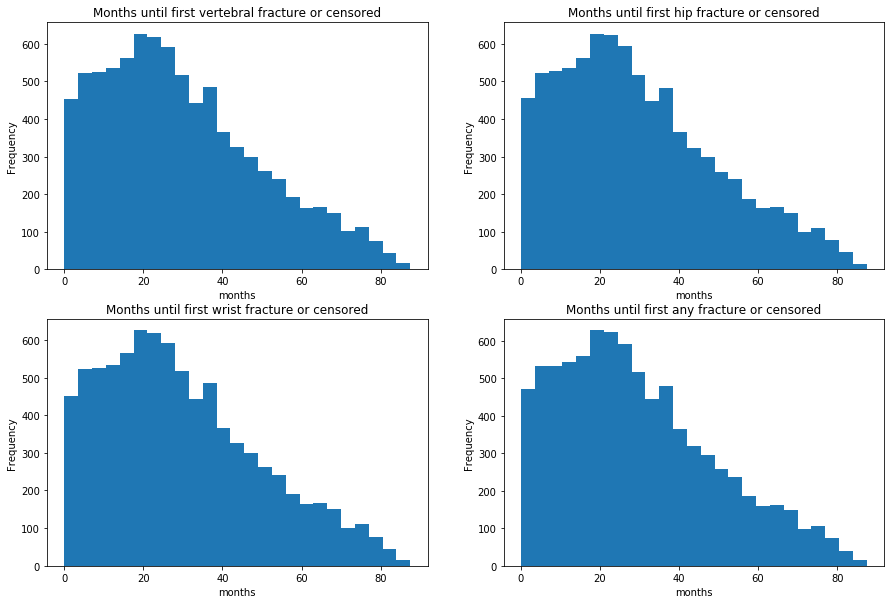

In [62]:
_, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, fx in enumerate(FX_TYPES):
    df_fx_final[df_fx_final[f"{fx}_fx"].notna()][f"{fx}_fx"].plot(kind="hist", bins=25, ax=axs[i//2][i%2])
    axs[i//2][i%2].set_xlabel("months")
    axs[i//2][i%2].set_title(f"Months until first {fx} fracture or censored")

In [64]:
df_fx_final[["imminent_fx", "previous_fx"]] = df_fx_final[["imminent_fx", "previous_fx"]].fillna(0)
df_fx_final.isna().sum()

eid                         0
dxa_date                    0
last_follow_up              0
vertebral_fx                0
hip_fx                      0
wrist_fx                    0
any_fx                      0
vertebral_right_censored    0
hip_right_censored          0
wrist_right_censored        0
any_right_censored          0
imminent_fx                 0
previous_fx                 0
dtype: int64

In [65]:
df_fx_final.to_csv("hesin_fractures.csv", index=False)

In [66]:
%%bash
dx upload hesin_fractures.csv --path /data/processed/

ID                          file-GPg1BVjJjxxP0PzFZ07b2qKF
Class                       file
Project                     project-GP77K38Jjxx9XzFP2KzPQyfG
Folder                      /data/processed
Name                        hesin_fractures.csv
State                       closing
Visibility                  visible
Types                       -
Properties                  -
Tags                        -
Outgoing links              -
Created                     Thu Feb 16 11:36:39 2023
Created by                  ollehman
 via the job                job-GPfzZk8Jjxx2KVPp1gfF1gZB
Last modified               Thu Feb 16 11:36:41 2023
Media type                  
archivalState               "live"
cloudAccount                "cloudaccount-dnanexus"
